In [1]:
import os
import pylcs
from repetitions import *
import numpy as np

from save_and_load import load_17_pieces_data

if not os.path.exists("./KuiSCIMA"):
    !git clone https://github.com/SuziAI/KuiSCIMA.git

pieces = load_17_pieces_data()
print(pieces.keys())

Cloning into 'KuiSCIMA'...
remote: Enumerating objects: 1635, done.
remote: Counting objects: 100% (634/634), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 1635 (delta 537), reused 566 (delta 482), pack-reused 1001 (from 1)
Receiving objects: 100% (1635/1635), 97.28 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (821/821), done.
dict_keys(['all', 'yanyue'])


# Preparations

## Distribution of Secondary Symbols

In [6]:
from collections import Counter
for piece in pieces["all"]:
    secondary_unified = [sec if sec not in ("ZHE", "YE") else "ZHE_YE" for sec in piece["music"]["secondary"]]
    print(secondary_unified[-1], secondary_unified[piece["cipai"]["meter"].index("pian")], piece["title"], len(secondary_unified), dict(Counter(secondary_unified)).keys())

XIAO_ZHU XIAO_ZHU 鬲溪梅令 48 dict_keys(['XIAO_ZHU', None, 'DING_ZHU', 'ZHE_YE'])
XIAO_ZHU XIAO_ZHU 杏花天影 58 dict_keys([None, 'DING_ZHU', 'XIAO_ZHU', 'ZHE_YE'])
XIAO_ZHU None 醉吟商小品 30 dict_keys([None, 'ZHE_YE', 'XIAO_ZHU'])
XIAO_ZHU XIAO_ZHU 玉梅令 66 dict_keys(['DING_ZHU', None, 'XIAO_ZHU', 'ZHE_YE'])
XIAO_ZHU XIAO_ZHU 霓裳中序第一 101 dict_keys([None, 'ZHE_YE', 'XIAO_ZHU', 'DING_ZHU'])
DA_DUN DA_DUN 扬州慢 98 dict_keys([None, 'DA_DUN', 'DING_ZHU', 'XIAO_ZHU', 'ZHE_YE', 'DA_ZHU'])
DA_DUN DA_DUN 長亭怨慢 97 dict_keys([None, 'ZHE_YE', 'DING_ZHU', 'DA_DUN', 'XIAO_ZHU'])
DA_DUN DA_DUN 淡黃柳 65 dict_keys([None, 'DING_ZHU', 'ZHE_YE', 'DA_ZHU', 'DA_DUN'])
DA_DUN DA_DUN 石湖仙 89 dict_keys([None, 'ZHE_YE', 'DING_ZHU', 'DA_DUN'])
DA_DUN DA_DUN 暗香 97 dict_keys([None, 'DA_DUN', 'ZHE_YE', 'DING_ZHU', 'DA_ZHU'])
DA_DUN DA_DUN 疏影 110 dict_keys([None, 'ZHE_YE', 'DING_ZHU', 'DA_DUN', 'DA_ZHU'])
DA_DUN DA_DUN 惜紅衣 88 dict_keys([None, 'DING_ZHU', 'DA_DUN', 'ZHE_YE', 'XIAO_ZHU'])
DA_DUN DA_DUN 角招 107 dict_keys(['ZHE_YE', None, 'X

## Stanza functions and lengths

In [14]:


def get_function_at_stanza_end(piece):
    pian_idx = None
    for idx, (pitch, cipai) in enumerate(zip(piece["music"]["relative_pitch"], piece["cipai"]["meter"])):
        if cipai == "pian":
            pian_idx = idx
            break
    return piece["music"]["relative_pitch"][pian_idx]

def get_function_at_end(piece):
    return piece["music"]["relative_pitch"][-1]

repetition_stats = {}
tone_stats = {}
meter_stats = {}
meter_less_stats = {}
secondary_stats = []
for piece in pieces["all"]:
    first_stanza_structure = get_sentence_lengths(piece["cipai"])[0]
    second_stanza_structure = get_sentence_lengths(piece["cipai"])[1]

    meter = [symbol if symbol != "" else " " for symbol in piece["cipai"]["meter"]]

    first_stanza_repetitions = piece["repetitions"][0:sum(first_stanza_structure)]
    second_stanza_repetitions = piece["repetitions"][sum(first_stanza_structure):]

    first_stanza_tones = piece["cipai"]["tones"][0:sum(first_stanza_structure)]
    second_stanza_tones = piece["cipai"]["tones"][sum(first_stanza_structure):]

    first_stanza_secondary = piece["music"]["secondary"][0:sum(first_stanza_structure)]
    second_stanza_secondary = piece["music"]["secondary"][sum(first_stanza_structure):]

    first_stanza_meter_less_strict = ["mark" if tone in ("ju", "pian", "dou") else " " for tone in piece["cipai"]["meter"][0:sum(first_stanza_structure)]]
    second_stanza_meter_less_strict = ["mark" if tone in ("ju", "pian", "dou") else " " for tone in piece["cipai"]["meter"][sum(first_stanza_structure):]]

    first_stanza_meter = ["ju" if tone == "pian" else tone for tone in meter[0:sum(first_stanza_structure)]]
    second_stanza_meter = ["ju" if tone == "pian" else tone for tone in meter[sum(first_stanza_structure):]]
    
    first_stanza_tones_conditioned_on_repeat = [tone for tone, repetition in zip(first_stanza_tones, first_stanza_repetitions) if repetition == "r"]
    second_stanza_tones_conditioned_on_repeat = [tone for tone, repetition in zip(second_stanza_tones, second_stanza_repetitions) if repetition == "r"]

    first_stanza_secondary_conditioned_on_repeat = [tone for tone, repetition in zip(first_stanza_secondary, first_stanza_repetitions) if repetition == "r"]
    second_stanza_secondary_conditioned_on_repeat = [tone for tone, repetition in zip(second_stanza_secondary, second_stanza_repetitions) if repetition == "r"]

    first_stanza_real_secondary_conditioned_on_repeat = [tone for tone, repetition in zip(first_stanza_secondary, first_stanza_repetitions) if repetition is not None]
    second_stanza_real_secondary_conditioned_on_repeat = [tone for tone, repetition in zip(second_stanza_secondary, second_stanza_repetitions) if repetition is not None]

    first_stanza_structure_conditioned_on_repeat = [struc for struc, repetition in zip(first_stanza_meter, first_stanza_repetitions) if repetition == "r"]
    second_stanza_structure_conditioned_on_repeat = [struc for struc, repetition in zip(second_stanza_meter, second_stanza_repetitions) if repetition == "r"]
    first_stanza_structure_less_conditioned_on_repeat = [struc for struc, repetition in zip(first_stanza_meter_less_strict, first_stanza_repetitions) if repetition == "r"]
    second_stanza_structure_less_conditioned_on_repeat = [struc for struc, repetition in zip(second_stanza_meter_less_strict, second_stanza_repetitions) if repetition == "r"]

    
    on_repeat_idxs = []
    
    if sum(first_stanza_structure) == sum(second_stanza_structure):
        print(piece["title"], "First and second stanza same length")
        if first_stanza_structure == second_stanza_structure:
            print("    ", "First and second stanza same structure", first_stanza_structure)
            print("    ", "Total tone repetition", f"{(np.array(first_stanza_tones)==np.array(second_stanza_tones)).mean()*100:.2f}")
    elif first_stanza_structure[:len(first_stanza_structure)//2] == first_stanza_structure[len(first_stanza_structure)//2:]:
        print(piece["title"], "First half stanzas same structure")
        print("    ", "Inside first stanza match tone %:", (np.array(first_stanza_tones[:len(first_stanza_tones)//2])==np.array(first_stanza_tones[len(first_stanza_tones)//2:])).mean()*100)
    else:
        print(piece["title"])
        
    if piece["title"] == "秋宵吟":
        print("    ", "Repetition %:                  ", f"{(np.array(piece["repetitions"])!=".").mean()*100:.2f} %")
        print(first_stanza_structure, second_stanza_structure)
    else:
        rep_percent = (np.array(piece["repetitions"])!=".").mean()*100
        print("    ", "Repetition %:                  ", f"{rep_percent:.2f} %")
        tone_match = (np.array(first_stanza_tones_conditioned_on_repeat)==np.array(second_stanza_tones_conditioned_on_repeat)).mean()*100
        meter_match = (np.array(first_stanza_structure_conditioned_on_repeat)==np.array(second_stanza_structure_conditioned_on_repeat)).mean()*100
        meter_less_match = (np.array(first_stanza_structure_less_conditioned_on_repeat)==np.array(second_stanza_structure_less_conditioned_on_repeat)).mean()*100
        secondary_match = (np.array(first_stanza_secondary_conditioned_on_repeat)==np.array(second_stanza_secondary_conditioned_on_repeat)).mean()*100
        secondary_match_nonempty = (np.array([x if x is None else "NOTNONE" for x in first_stanza_secondary_conditioned_on_repeat])==np.array([x if x is None else "NOTNONE" for x in second_stanza_secondary_conditioned_on_repeat])).mean()*100
        #real_secondary_match = (np.array(first_stanza_real_secondary_conditioned_on_repeat)==np.array(second_stanza_real_secondary_conditioned_on_repeat)).mean()*100
        print("    ", "Inside repetition match tone %:", tone_match)
        print("    ", "Inside repetition match struc%:", meter_match)
        print("    ", "Inside repetition less  struc%:", meter_less_match)
        print("    ", "Inside repetition match secon%:", secondary_match)
        print("    ", "Inside repetition match secon%:", secondary_match_nonempty)
        #print("    ", "Inside repetition real second%:", real_secondary_match)
        #print("    ", first_stanza_structure_conditioned_on_repeat)
        #print("    ", second_stanza_structure_conditioned_on_repeat)
        if rep_percent > 0:
            repetition_stats[piece["title"]] = rep_percent
            tone_stats[piece["title"]] = tone_match
            meter_stats[piece["title"]] = meter_match
            meter_less_stats[piece["title"]] = meter_less_match
        #print("    ", first_stanza_structure_conditioned_on_repeat)
        #print("    ", second_stanza_structure_conditioned_on_repeat)

    first_stanza_repetition_idxs = [idx for idx, repetition in enumerate(first_stanza_repetitions) if repetition == "r"]
    first_stanza_meter_str = "".join([s[0] for s in first_stanza_meter])
    second_stanza_meter_str = "".join([s[0] for s in second_stanza_meter])
    
    first_stanza_tone_str = "".join([s[0] for s in first_stanza_tones])
    second_stanza_tone_str = "".join([s[0] for s in second_stanza_tones])

    first_stanza_str = get_combined_str(first_stanza_meter_str, first_stanza_tone_str)
    second_stanza_str = get_combined_str(second_stanza_meter_str, second_stanza_tone_str)

    first_idxs = [idx for idx in pylcs.lcs_sequence_idx(second_stanza_str, first_stanza_str) if idx != -1]

    #first_tones_idxs = [idx for idx in pylcs.lcs_sequence_idx(second_stanza_tone_str, first_stanza_tone_str) if idx != -1]
    #second_tones_idxs = [idx for idx in pylcs.lcs_sequence_idx(first_stanza_tone_str, second_stanza_tone_str) if idx != -1]

    #first_meter_idxs = [idx for idx in pylcs.lcs_sequence_idx(second_stanza_meter_str, first_stanza_meter_str) if idx != -1]
    #second_meter_idxs = [idx for idx in pylcs.lcs_sequence_idx(first_stanza_meter_str, second_stanza_meter_str) if idx != -1]

    print("    ", "total intersection:", len(first_stanza_tone_str), len(first_idxs), len(first_stanza_repetition_idxs), len(set(first_idxs).intersection(set(first_stanza_repetition_idxs)))/len(first_stanza_repetition_idxs) if len(first_stanza_repetition_idxs) else 0) #/len(set(first_tones_idxs).union(set(first_stanza_repetition_idxs))))

    #print("    ", "total intersection:", len(first_stanza_tone_str), len(set(first_tones_idxs).intersection(set(first_meter_idxs))), len(first_stanza_repetition_idxs), len(set(first_tones_idxs).intersection(set(first_stanza_repetition_idxs)).intersection(set(first_meter_idxs)))/len(first_stanza_repetition_idxs) if len(first_stanza_repetition_idxs) else 0) #/len(set(first_tones_idxs).union(set(first_stanza_repetition_idxs))))
    #print("    ", "rep  intersection", len(first_stanza_meter_str), len(first_meter_idxs), len(first_stanza_repetition_idxs), len(set(first_meter_idxs).intersection(set(first_stanza_repetition_idxs)))/len(first_stanza_repetition_idxs) if len(first_stanza_repetition_idxs) else 0) #/len(set(first_rep_idxs).union(set(first_stanza_repetition_idxs))))
    #print("    ", "tone intersection", len(first_stanza_meter_str), len(first_tones_idxs), len(first_stanza_repetition_idxs), len(set(first_tones_idxs).intersection(set(first_stanza_repetition_idxs)))/len(first_stanza_repetition_idxs) if len(first_stanza_repetition_idxs) else 0) #/len(set(first_rep_idxs).union(set(first_stanza_repetition_idxs))))     
print()

鬲溪梅令 First and second stanza same length
     First and second stanza same structure [7, 3, 9, 5]
     Total tone repetition 100.00
     Repetition %:                   87.50 %
     Inside repetition match tone %: 100.0
     Inside repetition match struc%: 100.0
     Inside repetition less  struc%: 100.0
     Inside repetition match secon%: 95.23809523809523
     Inside repetition match secon%: 100.0
     total intersection: 24 24 21 1.0
杏花天影 First and second stanza same length
     First and second stanza same structure [7, 7, 7, 8]
     Total tone repetition 79.31
     Repetition %:                   75.86 %
     Inside repetition match tone %: 90.9090909090909
     Inside repetition match struc%: 100.0
     Inside repetition less  struc%: 100.0
     Inside repetition match secon%: 90.9090909090909
     Inside repetition match secon%: 95.45454545454545
     total intersection: 29 25 22 0.9090909090909091
醉吟商小品 First and second stanza same length
     First and second stanza same stru

/tmp/ipykernel_427801/113913167.py:72: RuntimeWarning: Mean of empty slice.
  tone_match = (np.array(first_stanza_tones_conditioned_on_repeat)==np.array(second_stanza_tones_conditioned_on_repeat)).mean()*100
/tmp/ipykernel_427801/113913167.py:73: RuntimeWarning: Mean of empty slice.
  meter_match = (np.array(first_stanza_structure_conditioned_on_repeat)==np.array(second_stanza_structure_conditioned_on_repeat)).mean()*100
/tmp/ipykernel_427801/113913167.py:74: RuntimeWarning: Mean of empty slice.
  meter_less_match = (np.array(first_stanza_structure_less_conditioned_on_repeat)==np.array(second_stanza_structure_less_conditioned_on_repeat)).mean()*100
/tmp/ipykernel_427801/113913167.py:75: RuntimeWarning: Mean of empty slice.
  secondary_match = (np.array(first_stanza_secondary_conditioned_on_repeat)==np.array(second_stanza_secondary_conditioned_on_repeat)).mean()*100
/tmp/ipykernel_427801/113913167.py:76: RuntimeWarning: Mean of empty slice.
  secondary_match_nonempty = (np.array([x if x

[('鬲溪梅令', np.float64(100.0)), ('杏花天影', np.float64(90.9090909090909)), ('玉梅令', np.float64(90.0)), ('霓裳中序第一', np.float64(100.0)), ('扬州慢', np.float64(82.6086956521739)), ('長亭怨慢', np.float64(79.16666666666666)), ('石湖仙', np.float64(100.0)), ('暗香', np.float64(78.37837837837837)), ('疏影', np.float64(84.78260869565217)), ('惜紅衣', np.float64(90.9090909090909)), ('角招', np.float64(82.35294117647058)), ('徴招', np.float64(86.04651162790698)), ('淒涼犯', np.float64(82.6086956521739)), ('翠樓吟', np.float64(93.18181818181817))]

[('鬲溪梅令', np.float64(100.0)), ('杏花天影', np.float64(100.0)), ('玉梅令', np.float64(100.0)), ('霓裳中序第一', np.float64(100.0)), ('扬州慢', np.float64(82.6086956521739)), ('長亭怨慢', np.float64(91.66666666666666)), ('石湖仙', np.float64(72.72727272727273)), ('暗香', np.float64(91.8918918918919)), ('疏影', np.float64(100.0)), ('惜紅衣', np.float64(100.0)), ('角招', np.float64(90.19607843137256)), ('徴招', np.float64(88.37209302325581)), ('淒涼犯', np.float64(91.30434782608695)), ('翠樓吟', np.float64(95.45454545454545))]


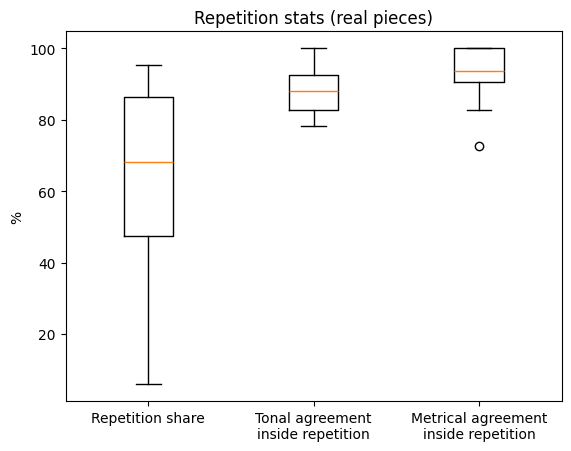

In [20]:
import matplotlib.pyplot as plt
print(list(zip(tone_stats.keys(), tone_stats.values())))
print()
print(list(zip(meter_stats.keys(), meter_stats.values())))
print()
repetition = np.array(list(repetition_stats.values()))
tone = np.array(list(tone_stats.values()))
meter = np.array(list(meter_stats.values()))

my_dict = {'Repetition share': repetition, 'Tonal agreement\ninside repetition': tone, 'Metrical agreement\ninside repetition': meter}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.title("Repetition stats (real pieces)")

plt.ylabel("%")
plt.savefig("real_repetitions.pdf")

print("TONE")
print(f"   mean:{tone.mean():.2f}, std:{tone.std():.2f}")
print(f"   min: {tone.min():.2f}, max:{tone.max():.2f}")
print("METER")
print(f"   mean:{meter.mean():.2f}, std:{meter.std():.2f}")
print(f"   min: {meter.min():.2f}, max:{meter.max():.2f}")

In [21]:
from repetitions import *
            
#[(m, t, r) for t, m, r in zip(ALL_PIECES[0]["cipai"]["tones"], ALL_PIECES[0]["cipai"]["meter"], generate_repetition(ALL_PIECES[0]["cipai"]))]

piece_idx = 3
#for x in range(10000):
#    generate_repetition(ALL_PIECES[np.random.randint(0, 17)]["cipai"])
genrep = generate_repetition(pieces["all"][piece_idx]["cipai"])["repetition"]
print(generate_repetition(pieces["all"][piece_idx]["cipai"])["description"])
genrep = "".join(genrep)
print(genrep)
print("".join([t[0] for t in pieces["all"][piece_idx]["cipai"]["tones"]]))
print("".join([t[0] if len(t) else " " for t in pieces["all"][piece_idx]["cipai"]["meter"]]))
real_rep = "".join(pieces["all"][piece_idx]["repetitions"])
print(real_rep)
print(pylcs.edit_distance(genrep, real_rep), f"{pylcs.edit_distance(genrep, real_rep)/len(real_rep):.2f}", f"{100*(1-pylcs.edit_distance(genrep, real_rep)/len(real_rep)):.2f}%")


In your selected cipai, the first and the second stanzas have no obvious metrical similarities, Therefore, the repetition pattern I chose for you specifically covers syllables in which the tonal agreement is high. In Baishidaoren Gequ, this is the case in most of the pieces.
......rrrr.....rrr....rrrr...rrrrr.....rrrr.....rrr....rrrr..rrrrr
ppzzzzppzppzzppzzzpzzzzzppppzzzpzzppzzpppzppzzpzzzzppzzzzpppzzzppz
   j    j  d   j    j    j   j   p   j   j  d   j    j    j  d   j
......rrrrrrrrrrrrrrrrrrrr.............rrrrrrrrrrrrrrrrrrrr.......
28 0.42 57.58%


/home/tristan/Desktop/git/SuziAI/SuziGEN/repetitions.py:44: RuntimeWarning: Mean of empty slice.
  second_stanza_tones_conditioned_on_repeat)).mean() * 100
/home/tristan/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tristan/Desktop/git/SuziAI/SuziGEN/repetitions.py:46: RuntimeWarning: Mean of empty slice.
  second_stanza_structure_conditioned_on_repeat)).mean() * 100


No Repetitions Share 0.1197142857142857
1676 1000


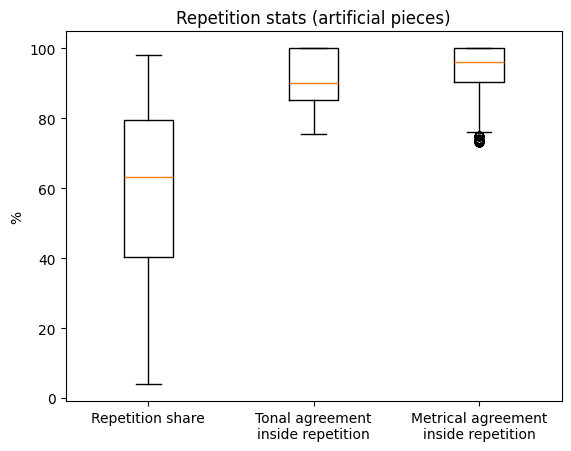

In [22]:
num_trials = 1000
artificial_repetition_stats = []
artificial_tone_stats = []
artificial_meter_stats =[]
no_repetitions = 0
for piece_idx in [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16]:  # exclude the pieces without repetition and the one with intra-strophal repetition
    for trial in range(num_trials):
        artificial_repetition = generate_repetition(pieces["all"][piece_idx]["cipai"])["repetition"]
        repetition_s, tone_s, meter_s = get_agreements(pieces["all"][piece_idx]["cipai"], artificial_repetition)
        if repetition_s != 0:
            artificial_repetition_stats.append(repetition_s)
            artificial_tone_stats.append(tone_s)
            artificial_meter_stats.append(meter_s)
        else:
            no_repetitions += 1

artificial_tone_stats = [value for value in artificial_tone_stats if not np.isnan(value)]
artificial_meter_stats = [value for value in artificial_meter_stats if not np.isnan(value)]

my_dict_2 = {"Repetition share": artificial_repetition_stats, 'Tonal agreement\ninside repetition': artificial_tone_stats, 'Metrical agreement\ninside repetition': artificial_meter_stats}

fig, ax = plt.subplots()
ax.boxplot(my_dict_2.values())
ax.set_xticklabels(my_dict_2.keys())
plt.title("Repetition stats (artificial pieces)")
plt.ylabel("%")

#plt.savefig("artificial_repetitions.pdf")

print("No Repetitions Share", no_repetitions/num_trials/14)
print(no_repetitions, num_trials)

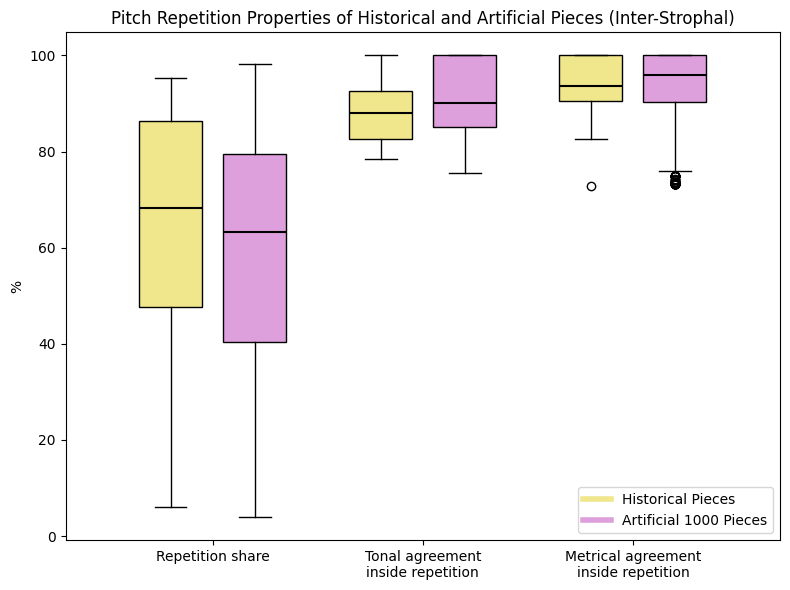

In [23]:
keys = list(my_dict_2.keys())
x_positions = np.arange(len(keys))

# Create positions for the boxplots
width = 0.3  # Width of each boxplot
gap = 0.1
positions_1 = x_positions - (width+gap) / 2  # Positions for dict_1
positions_2 = x_positions + (width+gap) / 2  # Positions for dict_2

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Custom mean properties
median_props = dict(color="black", linestyle="-", linewidth=1.5)

# Plot boxplots
bp1 = ax.boxplot([my_dict[k] for k in keys],
                 positions=positions_1,
                 widths=width,
                 patch_artist=True,
                 boxprops=dict(facecolor="khaki", alpha=1),
                 medianprops=median_props)
bp2 = ax.boxplot([my_dict_2[k] for k in keys],
                 positions=positions_2,
                 widths=width,
                 patch_artist=True,
                 boxprops=dict(facecolor="plum", alpha=1),
                 medianprops=median_props)

# Customizing the plot
ax.set_xticks(x_positions)
ax.set_xticklabels(keys)
#ax.set_xlabel('Keys')
ax.set_ylabel('%')
ax.set_title('Pitch Repetition Properties of Historical and Artificial Pieces (Inter-Strophal)')

# Add a legend
handles = [plt.Line2D([0], [0], color='khaki', lw=4, label='Historical Pieces'),
           plt.Line2D([0], [0], color='plum', lw=4, label='Artificial 1000 Pieces')]
ax.legend(handles=handles, loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()
fig.savefig("historical_artificial.pdf")

In [24]:
num_trials = 10000 # 6000

similarity_array = []
for piece_idx in range(17):
    max_similarity = 0
    for trial in range(num_trials):
        artificial_repetition = "".join(generate_repetition(pieces["all"][piece_idx]["cipai"])["repetition"])
        real_repetition = "".join(pieces["all"][piece_idx]["repetitions"])
        similarity = (np.array(list(artificial_repetition)) == np.array(list(real_repetition))).mean()
        max_similarity = max(max_similarity, similarity)
        if abs(max_similarity - similarity) < 1e-05:
            min_artificial_repetition = artificial_repetition
    similarity_array.append(max_similarity)
    print(pieces["all"][piece_idx]["title"], generate_repetition(pieces["all"][piece_idx]["cipai"])["description"])
    print(piece_idx, f"{max_similarity*100:.2f}%")
    print("   ", real_repetition)
    print("   ", min_artificial_repetition)
similarity_array = np.array(similarity_array)

print()
print("Mean:", similarity_array.mean(), "Std:", similarity_array.std())
print("Min:", similarity_array.min(), "Max:", similarity_array.max())

鬲溪梅令 In the cipai you provided, the first and the second stanzas have the same metrical structure, and also, the agreement of the Chinese syllable tones inside both stanzas is with 100.0% very high. Therefore, the repetition I chose for you is a large repetition in both stanzas. In Baishidaoren Gequ, this appears in the piece 鬲溪梅令 (Geximeiling).
0 100.00%
    rrrr...rrrrrrrrrrrrrrrrrrrrr...rrrrrrrrrrrrrrrrr
    rrrr...rrrrrrrrrrrrrrrrrrrrr...rrrrrrrrrrrrrrrrr
杏花天影 In the cipai you provided, the first and the second stanzas have the same metrical structure, but the agreement of the Chinese syllable tones inside both stanzas is with 79.3% not very high. Therefore, for building the repetition pattern I excluded the ju (sentences) where the agreement is low. In Baishidaoren Gequ, this appears in the piece 杏花天影 (Xinghuatianying).
1 100.00%
    .......rrrrrrrrrrrrrrrrrrrrrr.......rrrrrrrrrrrrrrrrrrrrrr
    .......rrrrrrrrrrrrrrrrrrrrrr.......rrrrrrrrrrrrrrrrrrrrrr
醉吟商小品 In the cipai you prov

/home/tristan/Desktop/git/SuziAI/SuziGEN/repetitions.py:44: RuntimeWarning: Mean of empty slice.
  second_stanza_tones_conditioned_on_repeat)).mean() * 100
/home/tristan/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tristan/Desktop/git/SuziAI/SuziGEN/repetitions.py:46: RuntimeWarning: Mean of empty slice.
  second_stanza_structure_conditioned_on_repeat)).mean() * 100


霓裳中序第一 In your selected cipai, the first and the second stanzas have no obvious metrical similarities, Therefore, the repetition pattern I chose for you specifically covers syllables in which the tonal agreement is high. In Baishidaoren Gequ, this is the case in most of the pieces.
4 100.00%
    ...............................................rrr................................................rrr
    ...............................................rrr................................................rrr
扬州慢 In your selected cipai, the first and the second stanzas have no obvious metrical similarities, Therefore, the repetition pattern I chose for you specifically covers syllables in which the tonal agreement is high. In Baishidaoren Gequ, this is the case in most of the pieces.
5 79.59%
    .........rr.rr......rrrr...........rrrrrrrrrrrrrrr......rr.rr.........rrrr.........rrrrrrrrrrrrrrr
    ..........rrrr......rrrrr..........rrr.......rrrrr.......rrrr.........rrrrr........rrr.......rrrrr


In [25]:
num_trials = 1000

diff_array = []
for piece_idx in [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16]:  # exclude the pieces without repetition and the one with intra-strophal repetition
    min_diff = 0
    for trial in range(num_trials):
        artificial_repetition = "".join(generate_repetition(pieces["all"][piece_idx]["cipai"])["repetition"])
        real_repetition = "".join(pieces["all"][piece_idx]["repetitions"])
        art_rep = set([i for i, r in enumerate(artificial_repetition) if r == "r"])
        real_rep = set([i for i, r in enumerate(real_repetition) if r == "r"])
        try:
            diff = len(art_rep.intersection(real_rep))/len(art_rep.union(real_rep))
        except ZeroDivisionError:
            diff = 1000
        min_diff = max(min_diff, diff)
        if abs(diff - min_diff) < 1e-05:
            min_artificial_repetition = artificial_repetition
    diff_array.append(min_diff)
    print(pieces["all"][piece_idx]["title"], generate_repetition(pieces["all"][piece_idx]["cipai"])["description"])
    print(piece_idx, f"{min_diff}")
    print("   ", real_repetition)
    print("   ", min_artificial_repetition)
diff_array = np.array(diff_array)

print()
print("Mean:", diff_array.mean(), "Std:", diff_array.std())
print("Min:", diff_array.min(), "Max:", diff_array.max())

鬲溪梅令 In the cipai you provided, the first and the second stanzas have the same metrical structure, and also, the agreement of the Chinese syllable tones inside both stanzas is with 100.0% very high. Therefore, the repetition I chose for you is a large repetition in both stanzas. In Baishidaoren Gequ, this appears in the piece 鬲溪梅令 (Geximeiling).
0 1.0
    rrrr...rrrrrrrrrrrrrrrrrrrrr...rrrrrrrrrrrrrrrrr
    rrrr...rrrrrrrrrrrrrrrrrrrrr...rrrrrrrrrrrrrrrrr
杏花天影 In the cipai you provided, the first and the second stanzas have the same metrical structure, but the agreement of the Chinese syllable tones inside both stanzas is with 79.3% not very high. Therefore, for building the repetition pattern I excluded the ju (sentences) where the agreement is low. In Baishidaoren Gequ, this appears in the piece 杏花天影 (Xinghuatianying).
1 1.0
    .......rrrrrrrrrrrrrrrrrrrrrr.......rrrrrrrrrrrrrrrrrrrrrr
    .......rrrrrrrrrrrrrrrrrrrrrr.......rrrrrrrrrrrrrrrrrrrrrr
玉梅令 As a repetition structure, I se

{'whiskers': [<matplotlib.lines.Line2D at 0x793f9a9847d0>,
 'caps': [<matplotlib.lines.Line2D at 0x793f9a987740>,
 'boxes': [<matplotlib.lines.Line2D at 0x793f9a984440>],
 'medians': [<matplotlib.lines.Line2D at 0x793f9a987b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x793f9a987da0>],
 'means': []}

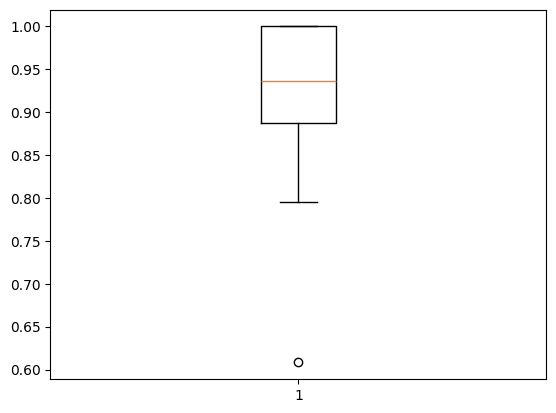

In [26]:
plt.boxplot(similarity_array)

#

In [27]:
from pitch_and_secondary import *

print(get_pitch_contour_distributions(pieces)["all"][("ping", "ping", "ping")])
print(get_pitch_contour_distributions(pieces)[-1][("ping", "ping", "ping")])

Distribution(
  (-1, -1): 2.2%
  (-1, 1): 39.1%
  (1, -1): 14.1%
  (1, 1): 44.6%
)
Distribution(
  -1: 5.3%
  1: 94.7%
)


In [28]:
from filter_and_conversion import *

print(f_S_to_N("GONG", "HUANGZHONG"))
print(f_N_to_S("HE", "HUANGZHONG"))
print(f_N_to_S("LIU", "HUANGZHONG"))
print()
print(add_mgong("HUANGZHONG", "HE", 3))
print(add_mgong("DALV", "SI", [0, 2, -2]))
print(get_suzipu_pitches("HUANGZHONG"))

['HE', 'LIU']
GONG
GONG

GOU
['SI', 'SI', 'SHANG', 'SI']
['HE', 'SI', 'YI', 'GOU', 'CHE', 'GONG', 'FAN', 'LIU', 'WU']


# 2. Mode Sampling

In [10]:
from mode import *
generate_mode(pieces)

{'mgong': 'YIZE',
 'mfinal': 'YU',
 'description': "For the mode, I chose 仙吕调 (Xian Lü Diao). I generate this in 6.7% of all cases. This mode occurs in these pieces of Baishidaoren Gequ: 鬲溪梅令 (Geximeiling), 淒涼犯 (Qiliangfan). This mode's final note is YU, which is also the final note of these pieces: 鬲溪梅令 (Geximeiling), 杏花天影 (Xinghuatianying), 玉梅令 (Yumeiling), 淡黃柳 (Danhuangliu), 淒涼犯 (Qiliangfan).",
 'probability': 0.06666666666666667}

In [11]:
from pitch_and_secondary import *

c_dists = get_pitch_contour_distributions(pieces)
f_dists = get_pitch_function_distributions(pieces)

print(c_dists)
print(f_dists)

{'all': {('ping', 'ze', 'ping'): Distribution(
  (-1, -1): 13.5%
  (-1, 1): 54.0%
  (1, -1): 8.7%
  (1, 1): 23.8%
), ('ze', 'ping', 'ping'): Distribution(
  (-1, -1): 1.7%
  (-1, 1): 17.6%
  (1, -1): 30.1%
  (1, 1): 50.6%
), ('ping', 'ping', 'ze'): Distribution(
  (-1, -1): 15.3%
  (-1, 1): 6.8%
  (1, -1): 47.0%
  (1, 1): 30.9%
), ('ping', 'ze', 'ze'): Distribution(
  (-1, -1): 36.7%
  (-1, 1): 29.1%
  (1, -1): 27.1%
  (1, 1): 7.0%
), ('ze', 'ze', 'ping'): Distribution(
  (-1, -1): 15.5%
  (-1, 1): 51.5%
  (1, -1): 8.5%
  (1, 1): 24.5%
), ('ping', 'ping', 'ping'): Distribution(
  (-1, -1): 2.2%
  (-1, 1): 39.1%
  (1, -1): 14.1%
  (1, 1): 44.6%
), ('ze', 'ping', 'ze'): Distribution(
  (-1, -1): 24.3%
  (-1, 1): 4.9%
  (1, -1): 54.4%
  (1, 1): 16.5%
), ('ze', 'ze', 'ze'): Distribution(
  (-1, -1): 45.6%
  (-1, 1): 24.3%
  (1, -1): 26.0%
  (1, 1): 4.1%
)}, -1: {('ping', 'ze', 'ping'): Distribution(
  -1: 20.0%
  1: 80.0%
), ('ze', 'ping', 'ping'): Distribution(
  -1: 8.7%
  1: 91.3%
), ('

# 3. Initial State

In [24]:

get_pitch_initial_state(triple_distributions=get_pitch_initial_state_distributions(pieces), contour_distributions=get_pitch_contour_distributions(pieces), mode=generate_mode(pieces), cipai=pieces["all"][0]["cipai"])

{'initial_state': ['YI', 'SI', 'SHANG'],
 'description': "Now, I will generate the pitches for you. Since the piece's ending is determined by the mode, I will first generate the cadential phrase at the end, consisting of three notes. According to the mode, the piece must end with YI. Therefore, I chose ['SHANG', 'SI', 'YI'] for you. This happens with a probability of 9.0%.",
 'probability': 0.08994708994708994}

# 4. Transition Probabilities

## Pitch MC

The base Markov chain is calculated for each mode. The n-1 step Markov chain is incorporated with a chance of 5% for the last n-1 entries. In case the 1-step Markov chain is empty, three random indices are chosen uniformly distributed.

In [26]:
#print(filter_by_final(pieces, "GONG"))

In [55]:
import copy

cipai = pieces["all"][0]["cipai"]
mode = generate_mode(pieces)
repetition = generate_repetition(cipai)
pitch_symbols = generate_pitch(cipai, mode, repetition)
print(pitch_symbols)

TypeError: get_pitch_initial_state() missing 2 required positional arguments: 'cipai' and 'mode'

# Secondary Model

For simplicity, it is assumed that the secondary symbols are independent of the mode and the melody. In the model, it should therefore only depend on the cipai pauses. It can be seen that real secondary symbols correlate heavily with cipai stops.

The final note of a piece has either DA_DUN or XIAO_ZHU for all of the 17 pieces. 12 of the pieces end in DA_DUN, while 5 of the pieces end in XIAO_ZHU. When filtering by this criterion, one sees that also the secondary symbols at cipai full stop positions have a strong correlation with the final note secondary symbol.

Xiaoling pieces (i.e., <= 58 syllables) have less diverse secondary symbols than the longer pieces. Therefore, for normal (i.e., non full stop) positions:

This is incorporated into the model as follows:

1. FINAL_SECONDARY: (DA_DUN: 70%, XIAO_ZHU: 30%)
2. For each full stop note: (FINAL_SECONDARY: 65%, NONE: 25%, DING_ZHU: 6%, NON_FINAL_SECONDARY: 1%, DA_ZHU: 1%, ZHE: 1%, YE: 1%)
3. Normal notes:
     * Take from Markov chain (except ZHE/YE)
4. Then, ZHE/YE generation from forward to backward

In [13]:
#print(get_all_with_secondary_first(pieces, "interval", 1, [SuzipuSecondarySymbol.ADD_ZHE]))
print(get_all_with_secondary_first(pieces, "function", 1, [SuzipuSecondarySymbol.ADD_ZHE]))
print(get_all_with_secondary_first(pieces, "function", 2, [SuzipuSecondarySymbol.ADD_ZHE]))
print(find_all_key(pieces, "function", ["ZHI", "BIAN"]))
print(find_all_key(pieces, "function", ["GONG", "SHANG"]))
print(find_all_key(pieces, "function", ["ZHI", "YU"]))
print(find_all_key(pieces, "function", ["GONG", "RUN"]))

NameError: name 'get_all_with_secondary_first' is not defined

In [44]:
#print(get_all_with_secondary_first(pieces, "interval", 1, [SuzipuSecondarySymbol.ADD_YE]))
print(get_all_with_secondary_first(pieces, "function", 2, [SuzipuSecondarySymbol.ADD_YE]))
print(find_all_key(pieces, "function", ["GONG", "YU"]))
print(find_all_key(pieces, "function", ["ZHI", "JUE"]))

    secondary
      1. ('GONG', 'YU'): 25.00% (20)
      2. ('ZHI', 'JUE'): 21.25% (17)
      3. ('SHANG', 'JUE'): 3.75% (3)
      4. ('ZHI', 'YU'): 3.75% (3)
      5. ('YU', 'ZHI'): 3.75% (3)
      6. ('GONG', 'JUE'): 3.75% (3)
      7. ('BIAN', 'JUE'): 3.75% (3)
      8. ('YU', 'BIAN'): 3.75% (3)
      9. ('SHANG', 'GONG'): 2.50% (2)
      10. ('ZHI', 'GONG'): 2.50% (2)
      11. ('JUE', 'ZHI'): 2.50% (2)
      12. ('GONG', 'SHANG'): 2.50% (2)
      13. ('YU', 'GONG'): 2.50% (2)
      14. ('ZHI', 'ZHI'): 2.50% (2)
      15. ('SHANG', 'RUN'): 1.25% (1)
      16. ('YU', 'SHANG'): 1.25% (1)
      17. ('JUE', 'GONG'): 1.25% (1)
      18. ('YU', 'JUE'): 1.25% (1)
      19. ('ZHI', 'BIAN'): 1.25% (1)
      20. ('BIAN', 'YU'): 1.25% (1)
      21. ('BIAN', 'SHANG'): 1.25% (1)
      22. ('YU', 'RUN'): 1.25% (1)
      23. ('RUN', 'SHANG'): 1.25% (1)
      24. ('JUE', 'SHANG'): 1.25% (1)
      25. ('GONG', 'RUN'): 1.25% (1)
      26. ('BIAN', 'GONG'): 1.25% (1)
      27. ('RUN', 'YU'): 1.25% (1

In [220]:
import copy

def remove_zhe_ye(l):
    new_list = []
    for element in l:
        if element in [SuzipuSecondarySymbol.ADD_ZHE, SuzipuSecondarySymbol.ADD_YE]:
            new_list.append(None)
        else:
            new_list.append(element)
    return new_list

def get_pieces_without_zhe_ye(pieces):
    new_pieces = copy.deepcopy(pieces)
    for idx in range(len(new_pieces)):
        new_pieces[idx]["music"]["secondary"] = remove_zhe_ye(new_pieces[idx]["music"]["secondary"])
    return new_pieces

def get_secondary_n_grams(piece, n):
    ngrams = []
    secondary_list = remove_zhe_ye(piece["music"]["secondary"])  # WE REMOVE ZHE AND YE, THEY ARE CALCULATED SEPARATELY
    pause_list = piece["cipai"]["pause"]
    for idx in range(len(secondary_list)-(n-1)):
        if pause_list[idx+n-1] not in FULL_PAUSE:  # exclude phrase endings
            ngrams.append(secondary_list[idx:(idx+n)])
    return ngrams


def get_inverted_n_step_markov_chain_secondary(base_pieces, n):
    total_list = []
    for piece in base_pieces:
        total_list += get_secondary_n_grams(piece, n=n+1)
    
    markov_chain = {}
    for combination in itertools.product(*[SimpleSecondaryList for idx in range(n)]):
        markov_chain[combination] = {}
        for symbol in SimpleSecondaryList:
            markov_chain[combination][symbol] = 0
    
    # add absolute count
    for ngram in total_list:
        ngram.reverse() # we must consider the inverted ngrams since we generate starting from the end
        triple = tuple(ngram[0:n])
        next_step = ngram[n]
        
        markov_chain[triple][next_step] += 1
    
    zero_rows = []
    # scale to probability vector
    for triple in itertools.product(*[SimpleSecondaryList for idx in range(n)]):
        row_sum = sum(markov_chain[triple].values())
        if row_sum < 1:
            zero_rows.append(triple)
        else:
            for symbol in SimpleSecondaryList:
                markov_chain[triple][symbol] /= row_sum             
           
    # incorporate n-1 step probabilites with 5%, except for zero rows
    if n > 1:
        n_minus_one_chain = get_inverted_n_step_markov_chain_secondary(base_pieces, n-1)

        for triple in itertools.product(*[SimpleSecondaryList for idx in range(n)]):
            if triple in zero_rows:
                for symbol in SimpleSecondaryList:
                    markov_chain[triple][symbol] = n_minus_one_chain[triple[1:n]][symbol]
            else:
                for symbol in SimpleSecondaryList:
                    markov_chain[triple][symbol] = 0.95 * markov_chain[triple][symbol] +  0.05 * n_minus_one_chain[triple[1:n]][symbol]
    else: # if zero, choose None Secondary Symbol
        for zero_row in zero_rows:
            markov_chain[zero_row][None] = 1
            
    return markov_chain


print(get_inverted_n_step_markov_chain_secondary(pieces, n=3))
print("-------------\n")


NameError: name 'SuzipuAdditionalSymbol' is not defined

In [46]:
def generate_ending_triple_secondary(final_secondary, is_final_ending):
    if final_secondary == SuzipuSecondarySymbol.ADD_DA_DUN:
        if is_final_ending:
            triple_space = [
                (None, None, 'DA_DUN'),
                ('DING_ZHU', None, 'DA_DUN'),
                ('DA_DUN', None, 'DA_DUN')
            ]
            space_probabilities = [
                5/12,
                4/12,
                3/12
            ]
        else:
            triple_space = [
                (None, None, 'DA_DUN'),
                (None, None, None),
                ('DING_ZHU', None, 'DA_DUN'),
                (None, None, 'DING_ZHU'),
                ('DA_DUN', None, 'DA_DUN'),
                ('XIAO_ZHU', None, 'DA_DUN'),
                (None, None, 'DA_ZHU'),
                (None, None, 'XIAO_ZHU'),
                ('DING_ZHU', 'DING_ZHU', 'DA_DUN'),
                ('DING_ZHU', None, 'DING_ZHU'),
                ('DING_ZHU', None, 'XIAO_ZHU'),
                ('DING_ZHU', None, None),
            ]
            space_probabilities = [
                40/102,
                22/102,
                18/102,
                6/102,
                5/102,
                2/102,
                2/102,
                2/102,
                2/102,
                1/102,
                1/102,
                1/102,
            ]
    else:
        if is_final_ending:
            triple_space = [
                (None, None, 'XIAO_ZHU'),
                ('XIAO_ZHU', None, 'XIAO_ZHU')
            ]
            space_probabilities = [
                3/5,
                2/5
            ]
        else:
            triple_space = [
                (None, None, 'XIAO_ZHU'),
                (None, None, None),
                ('XIAO_ZHU', None, 'XIAO_ZHU'),
                ('DING_ZHU', None, 'XIAO_ZHU'),
                (None, None, 'DING_ZHU')
            ]
            space_probabilities = [
                10/26,
                8/26,
                4/26,
                3/26,
                1/26
            ]
        
    index = np.random.choice(range(len(triple_space)), 1, p=space_probabilities)[0]
    return reversed(triple_space[index])

def generate_neutral_secondary(chain, current_triple):
    curr_row = chain[current_triple]
    index = np.random.choice(range(len(curr_row.keys())), 1, p=[prob for prob in curr_row.values()])[0]
    return list(curr_row.keys())[index]

def generate_zhe_ye(current_symbol, function_pair, current_pitch, mode):
    new_symbol = [None, 'ZHE', 'YE']
    
    if function_pair == ['ZHI', 'BIAN']:
        p = [0.49, 0.5, 0.01]
    elif function_pair == ['GONG', 'SHANG']:
        p = [0.77, 0.22, 0.01]
    elif function_pair == ['ZHI', 'YU']:
        p = [0.78, 0.18, 0.04]
    elif function_pair == ['GONG', 'RUN']:
        p = [0.69, 0.3, 0.01]
    elif function_pair == ['GONG', 'YU']:
        p = [0.61, 0.01, 0.38]
    elif function_pair == ['ZHI', 'JUE']:
        p = [0.59, 0.01, 0.4]
    elif function_pair in [['BIAN', 'RUN'],
                            ['BIAN', 'ZHI'],
                            ['GONG', 'BIAN'],
                            ['JUE', 'BIAN'],
                            ['RUN', 'GONG'],
                            ['SHANG', 'BIAN'],]:
        p = [0.99, 0.01, 0]
    elif function_pair in [['BIAN', 'GONG'],
                        ['BIAN', 'YU'],
                        ['GONG', 'JUE'],
                        ['JUE', 'GONG'],
                        ['JUE', 'ZHI'],
                        ['RUN', 'SHANG'],
                        ['RUN', 'YU'],
                        ['SHANG', 'GONG'],
                        ['SHANG', 'RUN'],
                        ['YU', 'BIAN'],
                        ['YU', 'GONG'],
                        ['YU', 'JUE'],
                        ['YU', 'RUN'],
                        ['YU', 'SHANG'],
                        ['YU', 'ZHI'],
                        ['ZHI', 'GONG'],
                        ['ZHI', 'ZHI'],]:
        p = [0.99, 0, 0.01]
    elif function_pair in [['BIAN', 'JUE'],
                            ['BIAN', 'SHANG'],
                            ['GONG', 'SHANG'],
                            ['GONG', 'RUN'],
                            ['GONG', 'YU'],
                            ['JUE', 'SHANG'],
                            ['SHANG', 'JUE'],
                            ['ZHI', 'JUE'],
                            ['ZHI', 'BIAN'],
                            ['ZHI', 'YU'],]:
        p = [0.99, 0.005, 0.005]
    else:
        p = [1, 0, 0]
        
    choice = np.random.choice(new_symbol, 1, p=p)[0]
    if not choice:
        choice = current_symbol
    
    # TODO prohibit ZHE/YE on highest pitch of mode?
    #if choice and current_pitch 
    #    choice = current_symbol
    
    return choice
    
def generate_secondary(cipai_pauses, mode, pitch_list):
    generated_piece = [None] * len(cipai_pauses)
    elements = SimpleSecondaryList
    
    augmented_cipai_pauses = get_augmented_cipai_pauses(cipai_pauses)
    augmented_cipai_pauses.reverse()  # later, list traverses from end to beginning
    
    secondary_markov_chain = get_inverted_n_step_markov_chain_secondary(ALL_PIECES, 3)
     
    function_list = relative_pitch_to_absolute_pitch(mode, pitch_list)
    function_list = absolute_pitch_to_function(mode, function_list)
    
    if np.random.rand() <= 0.7:
        FINAL_SECONDARY = SuzipuSecondarySymbol.ADD_DA_DUN
        full_stop_probabilities = [
            0.25, # NONE
            0.65, # DA_DUN -- FINAL
            0.01, # XIAO_ZHU -- NON_FINAL
            0.06, # DING_ZHU 
            0.01, # DA_ZHU 
            0.01, # ZHE 
            0.01 # YE
        ]
    else:
        FINAL_SECONDARY = SuzipuSecondarySymbol.ADD_XIAO_ZHU
        full_stop_probabilities = [
            0.25, # NONE
            0.01, # DA_DUN -- NON_FINAL
            0.65, # XIAO_ZHU -- FINAL
            0.06, # DING_ZHU 
            0.01, # DA_ZHU 
            0.01, # ZHE 
            0.01 # YE
        ]
        
    # BACKWARD PASS: Generate everything except ZHE/YE
        
    idx = 0
    while idx < len(generated_piece):
        if idx == 0: # ending of piece
            generated_piece[0:3] = generate_ending_triple_secondary(FINAL_SECONDARY, is_final_ending=True)
            idx += 3
        else:
            current_triple = tuple(generated_piece[idx-3:idx])
            if augmented_cipai_pauses[idx] == "FULL":
                triple = generate_ending_triple_secondary(FINAL_SECONDARY, is_final_ending=False)
                try:
                    generated_piece[idx:idx+3] = triple
                except IndexError:
                    try:
                        generated_piece[idx:idx+2] = triple[0:2]
                    except IndexError:
                        generated_piece[idx] = triple[0]
                idx += 3
            else:
                generated_piece[idx] = generate_neutral_secondary(secondary_markov_chain, current_triple)
                idx += 1
                
    generated_piece.reverse()
    
    # FORWARD PASS: Generate ZHE/YE
    
    for idx in range(len(generated_piece)):
        if cipai_pauses[idx] in FULL_PAUSE:
            continue  # full pauses can't get ZHE/YE
        else:
            if idx < len(generated_piece)-2:
                generated_piece[idx] = generate_zhe_ye(generated_piece[idx], function_list[idx:idx+2], pitch_list[idx], mode)
        
    return generated_piece
    
text_list = text_to_list(example_text)
print(text_list)
secondary_symbols = generate_secondary(cipai_pauses, mode, pitch_symbols)
print(secondary_symbols)

['好', '花', '不', '與', '殢', '香', '人，', '浪', '粼', '粼。', '又', '恐', '春', '風', '歸', '去', '綠', '成', '陰，', '玉', '鈿', '何', '處', '尋？', '木', '蘭', '雙', '槳', '夢', '中', '雲，', '小', '横', '陳。', '謾', '向', '孤', '山', '山', '下', '覔', '盈', '盈，', '翠', '禽', '啼', '一', '春。']
[None, 'DING_ZHU', None, 'YE', None, 'YE', None, None, None, None, 'DA_DUN', None, None, None, None, 'ZHE', None, 'YE', None, 'ZHE', 'DING_ZHU', None, None, 'XIAO_ZHU', None, 'DING_ZHU', 'ZHE', None, None, 'YE', None, 'DING_ZHU', 'ZHE', 'XIAO_ZHU', None, None, 'YE', None, None, 'DA_DUN', 'YE', None, None, None, None, 'XIAO_ZHU', None, 'XIAO_ZHU']


In [66]:
import sys
sys.path.append("../gui-tools")
from src.plugins.suzipu_lvlvpu_gongchepu.notes_to_image import write_to_musicxml

def text_to_musicxml(title, cipai_text):
    cipai_pauses = text_to_cipai_pauses(example_text)
    text_list = text_to_list(example_text)
    mode, pitch_list = generate_pitch(cipai_pauses)
    secondary_list = generate_secondary(cipai_pauses, mode, pitch_list)
    mode_obj = GongdiaoModeList().from_properties(mode)
    mode_string = mode_obj.name
    
    suzipu_list = [{"pitch": pitch, "secondary": secondary} for pitch, secondary in zip(pitch_list, secondary_list)]
    suzipu_list = mode_obj.convert_pitches_in_list(suzipu_list)
    #print([x for x in zip(pitch_list, text_list)])
    print(mode, mode_string)
    
    write_to_musicxml(
        file_path="./output.musicxml",
        suzipu_list=suzipu_list,
        lyrics_list=text_list,
        mode=mode_string,
        preface=mode
        )

example_text = pieces[0]["lyrics"]["string"]
#example_text = "燕雁无心，太湖西畔随云去。\n数峰清苦，商略黄昏雨。\n第四桥边，拟共天随住。\n今何许？凭阑怀古，残柳参差舞。"
#print(example_text)
text_to_musicxml("鬲溪梅令", example_text)

{'final_note': 'YU', 'gong_lvlv': 'DALV'} Gao Ban She Diao


# Derivations

In [172]:
# SECONDARY ENDING TRIPLETS

pieces_without_zhe_ye = get_pieces_without_zhe_ye(pieces)
filtered = filter_by_final_secondary(pieces_without_zhe_ye, SuzipuSecondarySymbol.ADD_DA_DUN)
print(get_finals(filtered, "secondary", 3, title="All finals"))
print(get_full_stop_finals(filtered, "secondary", 3, title="All full stops"))

   All finals finals
      1. (None, None, 'DA_DUN'): 41.67% (5)
      2. ('DING_ZHU', None, 'DA_DUN'): 33.33% (4)
      3. ('DA_DUN', None, 'DA_DUN'): 25.00% (3)

   All full stops finals
      1. (None, None, 'DA_DUN'): 39.22% (40)
      2. (None, None, None): 21.57% (22)
      3. ('DING_ZHU', None, 'DA_DUN'): 17.65% (18)
      4. (None, None, 'DING_ZHU'): 5.88% (6)
      5. ('DA_DUN', None, 'DA_DUN'): 4.90% (5)
      6. ('XIAO_ZHU', None, 'DA_DUN'): 1.96% (2)
      7. (None, None, 'DA_ZHU'): 1.96% (2)
      8. (None, None, 'XIAO_ZHU'): 1.96% (2)
      9. ('DING_ZHU', 'DING_ZHU', 'DA_DUN'): 1.96% (2)
      10. ('DING_ZHU', None, 'DING_ZHU'): 0.98% (1)
      11. ('DING_ZHU', None, 'XIAO_ZHU'): 0.98% (1)
      12. ('DING_ZHU', None, None): 0.98% (1)



In [173]:
# SECONDARY ENDING TRIPLETS

pieces_without_zhe_ye = get_pieces_without_zhe_ye(pieces)
filtered = filter_by_final_secondary(pieces_without_zhe_ye, SuzipuSecondarySymbol.ADD_XIAO_ZHU)
print(get_finals(filtered, "secondary", 3, title="All finals"))
print(get_full_stop_finals(filtered, "secondary", 3, title="All full stops"))

   All finals finals
      1. (None, None, 'XIAO_ZHU'): 60.00% (3)
      2. ('XIAO_ZHU', None, 'XIAO_ZHU'): 40.00% (2)

   All full stops finals
      1. (None, None, 'XIAO_ZHU'): 38.46% (10)
      2. (None, None, None): 30.77% (8)
      3. ('XIAO_ZHU', None, 'XIAO_ZHU'): 15.38% (4)
      4. ('DING_ZHU', None, 'XIAO_ZHU'): 11.54% (3)
      5. (None, None, 'DING_ZHU'): 3.85% (1)



In [30]:
print(get_finals(pieces, "secondary", 1, title="All finals"))
print(get_full_stop_finals(pieces, "secondary", 1, title="All full stops"))
print(get_except_full_stop(pieces, "secondary", 1, title="Normal"))

   All finals finals
      1. ('DA_DUN',): 70.59% (12)
      2. ('XIAO_ZHU',): 29.41% (5)

   All full stops finals
      1. ('DA_DUN',): 52.34% (67)
      2. (None,): 24.22% (31)
      3. ('XIAO_ZHU',): 15.62% (20)
      4. ('DING_ZHU',): 6.25% (8)
      5. ('DA_ZHU',): 1.56% (2)

   Normal not full stop
      1. (None,): 76.56% (1006)
      2. ('DING_ZHU',): 8.68% (114)
      3. ('YE',): 6.09% (80)
      4. ('ZHE',): 5.40% (71)
      5. ('XIAO_ZHU',): 1.83% (24)
      6. ('DA_DUN',): 1.14% (15)
      7. ('DA_ZHU',): 0.30% (4)



In [18]:
fpieces = [piece for piece in pieces if piece["music"]["secondary"][-1] == SuzipuSecondarySymbol.ADD_DA_DUN]
print("DA_DUN Pieces")
print(get_finals(fpieces, "secondary", 1, title="All finals"))
print(get_full_stop_finals(fpieces, "secondary", 1, title="All full stops"))

fpieces = [piece for piece in pieces if piece["music"]["secondary"][-1] == SuzipuSecondarySymbol.ADD_XIAO_ZHU]
print("XIAO_ZHU Pieces")
print(get_finals(fpieces, "secondary", 1, title="All finals"))
print(get_full_stop_finals(fpieces, "secondary", 1, title="All full stops"))

DA_DUN Pieces
   All finals finals
      1. ('DA_DUN',): 100.00% (12)

   All full stops finals
      1. ('DA_DUN',): 65.69% (67)
      2. (None,): 22.55% (23)
      3. ('DING_ZHU',): 6.86% (7)
      4. ('XIAO_ZHU',): 2.94% (3)
      5. ('DA_ZHU',): 1.96% (2)

XIAO_ZHU Pieces
   All finals finals
      1. ('XIAO_ZHU',): 100.00% (5)

   All full stops finals
      1. ('XIAO_ZHU',): 65.38% (17)
      2. (None,): 30.77% (8)
      3. ('DING_ZHU',): 3.85% (1)



In [19]:
fpieces = [piece for piece in pieces if len(piece["music"]["secondary"]) <= 58]
print("Xiaoling Pieces")
print(get_except_full_stop(fpieces, "secondary", 1, title="Normal"))

fpieces = [piece for piece in pieces if 59 <= len(piece["music"]["secondary"]) <= 90]
print("Zhongdiao Pieces")
print(get_except_full_stop(fpieces, "secondary", 1, title="Normal"))

fpieces = [piece for piece in pieces if 91 <= len(piece["music"]["secondary"])]
print("Changdiao Pieces")
print(get_except_full_stop(fpieces, "secondary", 1, title="Normal"))

Xiaoling Pieces
   Normal not full stop
      1. (None,): 70.16% (87)
      2. ('ZHE',): 11.29% (14)
      3. ('XIAO_ZHU',): 8.87% (11)
      4. ('DING_ZHU',): 8.87% (11)
      5. ('YE',): 0.81% (1)

Zhongdiao Pieces
   Normal not full stop
      1. (None,): 72.40% (202)
      2. ('DING_ZHU',): 11.47% (32)
      3. ('YE',): 8.96% (25)
      4. ('ZHE',): 3.58% (10)
      5. ('XIAO_ZHU',): 1.43% (4)
      6. ('DA_DUN',): 1.43% (4)
      7. ('DA_ZHU',): 0.72% (2)

Changdiao Pieces
   Normal not full stop
      1. (None,): 78.70% (717)
      2. ('DING_ZHU',): 7.79% (71)
      3. ('YE',): 5.93% (54)
      4. ('ZHE',): 5.16% (47)
      5. ('DA_DUN',): 1.21% (11)
      6. ('XIAO_ZHU',): 0.99% (9)
      7. ('DA_ZHU',): 0.22% (2)



## Ending Triples

Instead of only sampling from all endings of all modes with this final note, the ending triplets are sampled from all full stop position intervals, but only those that end in the correct final note, and converted to the corresponding scale. If an entry doesn't fit the scale, i.e., it contains notes either below or above the pitch inventory, it is discarded. This is done both for the given mode's final note, and for all modes together.

For each mode, the mode-dependent list is preferred, while the all-mode-together list is also incorporated due to the scarcity of the data for introduction of new recombinations into the generated pieces.

A similar procedure is employed for the endings of full stop phrases, for the details, see section **Phrase Endings of Pieces (Function)**.

In [15]:
def get_full_stop_finals_ending_in_function(base_pieces, key, n, title=""):
    total_list = []
    for piece in base_pieces:
        for idx, lyric in enumerate(piece["cipai"]["pause"]):
            if lyric in FULL_PAUSE and piece["music"]["function"][idx] == piece["music"]["function"][-1]:
                #print(piece["lyrics"]["list"][idx], piece["music"][key][idx])
                if key == "interval":
                    total_list.append(tuple(piece["music"][key][idx-n:idx]))
                else:
                    total_list.append(tuple(piece["music"][key][idx+1-n:idx+1]))
    
    count = {}
    for final in total_list:
        try:
            count[final] += 1
        except KeyError:
            count[final] = 1
            
    count = dict(sorted(count.items(), key=lambda x: x[1], reverse=True))
    
    return_str = f"   {title} finals\n"
    for idx, key in enumerate(count.keys()):
        return_str += f"      {idx+1}. {key}: {count[key]/sum(list(count.values()))*100:.2f}% ({count[key]})\n"

    return return_str

print(get_full_stop_finals_ending_in_function(pieces, "interval", 2, title="All full stop with final function"))
for final_note in [GongdiaoStep.GONG, GongdiaoStep.SHANG, GongdiaoStep.YU]:
    print(final_note)
    print(get_full_stop_finals_ending_in_function(filter_by_final(pieces, final_note), "interval", 2, title="All full stop with final function"))

   All full stop with final function finals
      1. (1, -1): 50.00% (31)
      2. (2, -2): 11.29% (7)
      3. (-1, -1): 9.68% (6)
      4. (-1, 1): 6.45% (4)
      5. (1, 1): 4.84% (3)
      6. (3, -1): 3.23% (2)
      7. (-2, 1): 1.61% (1)
      8. (1, 4): 1.61% (1)
      9. (3, -2): 1.61% (1)
      10. (-5, 3): 1.61% (1)
      11. (5, -1): 1.61% (1)
      12. (-1, 2): 1.61% (1)
      13. (-4, 2): 1.61% (1)
      14. (1, 2): 1.61% (1)
      15. (2, 1): 1.61% (1)

GONG
   All full stop with final function finals
      1. (1, -1): 78.26% (18)
      2. (3, -1): 8.70% (2)
      3. (1, 4): 4.35% (1)
      4. (-5, 3): 4.35% (1)
      5. (5, -1): 4.35% (1)

SHANG
   All full stop with final function finals
      1. (1, -1): 69.23% (9)
      2. (1, 1): 7.69% (1)
      3. (-1, 1): 7.69% (1)
      4. (2, -2): 7.69% (1)
      5. (1, 2): 7.69% (1)

YU
   All full stop with final function finals
      1. (-1, -1): 26.67% (4)
      2. (-1, 1): 20.00% (3)
      3. (2, -2): 20.00% (3)
      4. (1, 

## Phrase Endings of Pieces (Functions)

For the phrase endings of the pieces, the Here, only the "orthodox" modes which appear in Baishidaoren Gequ are considered, i.e., on Gong, Shang and Yu. The two pieces on Jue and Zhi are therefore excluded. The model is as follows:

50% FINAL_NOTE, 30% final note specific second most frequent phrase ending, 4% each of the remaining four functions

In [16]:
final = GongdiaoStep.GONG
#print(get_ngram_statistics(filtered_pieces, "function", 1, title="All"))
#print(get_finals(filtered_pieces, "function", 1, title="Finals"))
print(get_full_stop_finals(filter_by_final(pieces, final), "function", 1, title=f"At full stop {final}"))

print("-------------\n")
final = GongdiaoStep.SHANG
#print(get_ngram_statistics(filtered_pieces, "function", 1, title="All"))
#print(get_finals(filtered_pieces, "function", 1, title="Finals"))
print(get_full_stop_finals(filter_by_final(pieces, final), "function", 1, title=f"At full stop {final}"))
print("-------------\n")

final = GongdiaoStep.YU
#print(get_ngram_statistics(filtered_pieces, "function", 1, title="All"))
#print(get_finals(filtered_pieces, "function", 1, title="Finals"))
print(get_full_stop_finals(filter_by_final(pieces, final), "function", 1, title=f"At full stop {final}"))
#print(get_non_full_finals(filtered_pieces, "function", 1, title="At non-full stop"))


   At full stop GONG finals
      1. ('GONG',): 45.10% (23)
      2. ('JUE',): 25.49% (13)
      3. ('YU',): 17.65% (9)
      4. ('ZHI',): 7.84% (4)
      5. ('SHANG',): 3.92% (2)

-------------

   At full stop SHANG finals
      1. ('SHANG',): 44.83% (13)
      2. ('YU',): 31.03% (9)
      3. ('BIAN',): 13.79% (4)
      4. ('JUE',): 10.34% (3)

-------------

   At full stop YU finals
      1. ('YU',): 51.72% (15)
      2. ('JUE',): 34.48% (10)
      3. ('RUN',): 6.90% (2)
      4. ('GONG',): 3.45% (1)
      5. ('SHANG',): 3.45% (1)



In [17]:
print(get_ngram_statistics(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="All"))
print(get_finals(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="Finals"))
print(get_full_stop_finals(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="At full stop"))
print(get_non_full_finals(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="At non-full stop"))
print(get_one_after_full_stop_finals(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="After full stop"))
print(get_one_after_non_full_final(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="After non full stop"))

   All function 1-gram frequency
      1. ('JUE',): 21.32% (126)
      2. ('GONG',): 18.95% (112)
      3. ('YU',): 18.27% (108)
      4. ('ZHI',): 15.40% (91)
      5. ('SHANG',): 14.89% (88)
      6. ('BIAN',): 7.11% (42)
      7. ('RUN',): 4.06% (24)

   Finals finals
      1. ('GONG',): 100.00% (6)

   At full stop finals
      1. ('GONG',): 45.10% (23)
      2. ('JUE',): 25.49% (13)
      3. ('YU',): 17.65% (9)
      4. ('ZHI',): 7.84% (4)
      5. ('SHANG',): 3.92% (2)

   At non-full stop finals
      1. ('JUE',): 39.13% (27)
      2. ('YU',): 20.29% (14)
      3. ('ZHI',): 14.49% (10)
      4. ('GONG',): 11.59% (8)
      5. ('SHANG',): 7.25% (5)
      6. ('RUN',): 7.25% (5)

   After full stop finals
      1. ('YU',): 19.61% (10)
      2. ('JUE',): 17.65% (9)
      3. ('GONG',): 17.65% (9)
      4. (): 11.76% (6)
      5. ('RUN',): 9.80% (5)
      6. ('SHANG',): 9.80% (5)
      7. ('ZHI',): 9.80% (5)
      8. ('BIAN',): 3.92% (2)

   After non full stop finals
      1. ('YU',):

## Zero Interval

The 1-gram interval curve over all pieces shows that the pitches are concentrated for intervals around 0, except for the zero interval itself (i.e., repeating the same pitch). The zero interval is with a relative frequency of 1.54% (22 occurrences) very seldom, and 17 out of those 22 occurrences (~77%) are directly after full stops or after partial stops as indicated by the cipai.

Therefore, the zero interval will be included in the Markov model as follows:
 * Normal interval: 0.3%
 * After partial pause: 2.3%
 * After full pause: 10.2%
 * At full pause: 0%
 * At beginning: 0%

In [ ]:
plot_n_grams(pieces, "interval", 1, title="All")
print(get_ngram_statistics(pieces, "interval", 1, title="All"))
print(get_firsts(pieces, "interval", 1, title="Beginning"))
print(get_full_stop_finals(pieces, "interval", 1, title="All full stop"))
print(get_one_after_full_stop_finals(pieces, "interval", 1, title="All after full stop"))
print(get_one_after_non_full_final(pieces, "interval", 1, title="All after non full stop"))

## Beginning of Pieces

Regarding the beginnings of the pieces, the auxiliary functions BIAN and RUN never occur in the data. This should also be reflected in the Markov model. Due to data scarcity of the finals (only 17 realizations in total), a simplified model for piece beginning is proposed in dependence on the final note as follows:

50% FINAL_NOTE, others with 12.5% each.

Beginnings of phrases are not modeled separately, since they do not show a clear trend without mode-specific analysis. 

In [ ]:
print(get_firsts(pieces, "function", 1, title="Beginnings"))
print("----------------\n")
print(get_firsts(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title=f"Beginnings {GongdiaoStep.GONG}"))
print(get_firsts(filter_by_final(pieces, GongdiaoStep.SHANG), "function", 1, title=f"Beginnings {GongdiaoStep.SHANG}"))
print(get_firsts(filter_by_final(pieces, GongdiaoStep.JUE), "function", 1, title=f"Beginnings {GongdiaoStep.JUE}"))
print(get_firsts(filter_by_final(pieces, GongdiaoStep.ZHI), "function", 1, title=f"Beginnings {GongdiaoStep.ZHI}"))
print(get_firsts(filter_by_final(pieces, GongdiaoStep.YU), "function", 1, title=f"Beginnings {GongdiaoStep.YU}"))
print("----------------\n")
print(get_one_after_full_stop_finals(filter_by_final(pieces, GongdiaoStep.GONG), "function", 1, title="All after full stop"))
print(get_one_after_full_stop_finals(filter_by_final(pieces, GongdiaoStep.SHANG), "function", 1, title="All after full stop"))
print(get_one_after_full_stop_finals(filter_by_final(pieces, GongdiaoStep.JUE), "function", 1, title="All after full stop"))
print(get_one_after_full_stop_finals(filter_by_final(pieces, GongdiaoStep.ZHI), "function", 1, title="All after full stop"))
print(get_one_after_full_stop_finals(filter_by_final(pieces, GongdiaoStep.YU), "function", 1, title="All after full stop"))